In [1]:
import arviz as az
import arviz_plots as azp
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.special as jss
import marimo as mo
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns

azp.style.use("arviz-vibrant")

/Users/curro/Documents/Dev/handbook-abc-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Synthetic Likelihood MCMC (BSL / uBSL)

## References

[Approximating the Likelihood in Approximate Bayesian Computation](https://arxiv.org/pdf/1803.06645)

The intuitive approach is to approximate the summary statistic as a multivariate normal distribution, with mean and covariance estimated from simulated replicates at each parameter value.

In [2]:
def log_synlik_bsl(s_replicates, s_obs):
    """
    BSL log-likelihood: plug-in MLE of multivariate normal.

    Args:
        s_replicates: (n, d) — summary stats from n simulations
        s_obs: (d,) — observed summary stat

    Returns:
        scalar log-likelihood estimate
    """
    mu_n = jnp.mean(s_replicates, axis=0)
    Sigma_n = jnp.atleast_2d(jnp.cov(s_replicates.T))
    return dist.MultivariateNormal(mu_n, Sigma_n).log_prob(s_obs)


def log_synlik_ubsl(s_replicates, s_obs):
    """
    uBSL log-likelihood: exactly unbiased via Ghurye & Olkin (1969).

    Requires n > d + 3 where n = num_replicates and d = dim(s_obs).

    Args:
        s_replicates: (n, d) — summary stats from n simulations
        s_obs: (d,) — observed summary stat

    Returns:
        scalar unbiased log-likelihood estimate
    """
    n = s_replicates.shape[0]
    d = s_obs.shape[0]

    mu_n = jnp.mean(s_replicates, axis=0)
    Sigma_n = jnp.atleast_2d(jnp.cov(s_replicates.T))
    M_n = (n - 1) * Sigma_n  # scatter matrix

    def log_c(k, v):
        """log of normalizing constant c(k, v) from Ghurye & Olkin (1969)."""
        i = jnp.arange(1, k + 1, dtype=jnp.float32)
        return (
            -k * v / 2 * jnp.log(2.0)
            - k * (k - 1) / 4 * jnp.log(jnp.pi)
            - jnp.sum(jss.gammaln(0.5 * (v - i + 1)))
        )

    log_ratio = log_c(d, n - 2) - log_c(d, n - 1)
    log_prefactor = (
        -d / 2 * jnp.log(2 * jnp.pi) + log_ratio - d / 2 * jnp.log(1.0 - 1.0 / n)
    )

    sign_Mn, log_det_Mn = jnp.linalg.slogdet(M_n)

    diff = s_obs - mu_n
    A = M_n - jnp.outer(diff, diff) / (1.0 - 1.0 / n)
    sign_A, log_det_A = jnp.linalg.slogdet(A)

    log_psi = jnp.where(sign_A > 0, (n - d - 3) / 2 * log_det_A, -jnp.inf)

    return jnp.where(
        sign_Mn > 0,
        log_prefactor - (n - d - 2) / 2 * log_det_Mn + log_psi,
        -jnp.inf,
    )


def synthetic_likelihood_mcmc(
    key,
    log_prior_density,
    proposal_covariance,
    initial_positions,
    simulator,
    summary_stat,
    num_replicates,
    num_samples,
    s_obs,
    log_synlik_fn,
):
    """
    Synthetic Likelihood MCMC via random-walk Metropolis-Hastings.

    At each step, num_replicates summary statistics are simulated to estimate
    the synthetic log-likelihood (BSL or uBSL). The simulator is called via
    a nested jax.lax.scan, which is safe when it uses pure_callback internally.

    Args:
        key: JAX random key
        log_prior_density: function log π(θ)
        proposal_covariance: covariance matrix for the random-walk proposal
        initial_positions: list of initial position dicts, one per chain
        simulator: function (key, params) -> y (may use numpy internally)
        summary_stat: function S(y) computing summary statistics
        num_replicates: number of simulator runs per MCMC step
        num_samples: number of MCMC steps per chain
        s_obs: observed summary statistics (d,)
        log_synlik_fn: log_synlik_bsl or log_synlik_ubsl

    Returns:
        az.InferenceData with shape (len(initial_positions), num_samples)
    """
    num_chains = len(initial_positions)
    s_obs_vec = jnp.atleast_1d(s_obs)

    def _compute_log_prob(theta, sim_key):
        sim_keys = jax.random.split(sim_key, num_replicates)
        lp = log_prior_density({"theta": theta})
        # Return early if prior is -inf to avoid unnecessary simulations
        lp = jnp.where(jnp.isfinite(lp), lp, -jnp.inf)

        def fn(theta, sim_key):
            _, s_replicates = jax.lax.scan(
                lambda _, k: (
                    None,
                    jnp.atleast_1d(summary_stat(simulator(k, {"theta": theta}))),
                ),
                None,
                sim_keys,
            )
            return log_synlik_fn(s_replicates, s_obs_vec)

        ll = jax.lax.cond(
            jnp.isfinite(lp).squeeze(),
            lambda _: fn(theta, sim_key),
            lambda _: -jnp.inf,
            operand=lp,
        )
        return jnp.squeeze(lp + ll)

    def _run_chain(args):
        init_pos, chain_key = args

        def one_step(carry, step_key):
            theta, log_prob_curr = carry
            step_key, prop_key, sim_key = jax.random.split(step_key, 3)

            theta_prop = theta + jax.random.normal(prop_key) * jnp.sqrt(
                proposal_covariance[0, 0]
            )
            log_prob_prop = _compute_log_prob(theta_prop, sim_key)

            log_accept_ratio = log_prob_prop - log_prob_curr
            # -inf - (-inf) = NaN; treat as -inf so the chain stays put
            # rather than accepting/rejecting randomly via a broken comparison
            log_accept_ratio = jnp.where(
                jnp.isnan(log_accept_ratio), -jnp.inf, log_accept_ratio
            )
            accept = jax.random.uniform(step_key) < jnp.exp(log_accept_ratio)

            new_theta = jnp.where(accept, theta_prop, theta)
            new_log_prob = jnp.where(accept, log_prob_prop, log_prob_curr)

            return (new_theta, new_log_prob), new_theta

        all_keys = jax.random.split(chain_key, num_samples)
        theta0 = init_pos["theta"]
        log_prob0 = _compute_log_prob(theta0, all_keys[0])
        _, theta_samples = jax.lax.scan(one_step, (theta0, log_prob0), all_keys)
        return theta_samples

    chain_keys = jax.random.split(key, num_chains)

    stacked_init = jax.tree.map(
        lambda *arrays: jnp.stack(arrays, axis=0), *initial_positions
    )

    all_theta_samples = []
    for i in range(num_chains):
        init_pos = {k: v[i] for k, v in stacked_init.items()}
        theta_samples = _run_chain((init_pos, chain_keys[i]))
        all_theta_samples.append(theta_samples)

    all_theta = jnp.stack(all_theta_samples, axis=0)
    posterior_dict = {"theta": np.asarray(all_theta)}
    return az.from_dict(posterior=posterior_dict)

## Example (from the book)

Suppose the model is specified as $y_1, \dots, y_{50} \sim \text{Poisson}(\theta)$, with uniform prior $\theta \sim U(0, 10)$.

In [3]:
theta_true = 2.5
observed_y = dist.Poisson(theta_true).sample(jr.key(1), (50,)).astype(jnp.float32)
observed_y

Array([4., 2., 1., 1., 3., 2., 1., 0., 5., 2., 2., 6., 5., 3., 2., 3., 2.,
       5., 5., 0., 5., 3., 2., 2., 2., 4., 2., 3., 2., 3., 0., 7., 1., 2.,
       4., 1., 6., 1., 2., 4., 3., 3., 2., 2., 3., 2., 4., 2., 4., 3.],      dtype=float32)

In [4]:
# Define prior distribution
prior = dist.Uniform(0, 10, validate_args=True)
log_prior_density = lambda params: prior.log_prob(params["theta"])
# Sufficient summary statistic
summary_stat = lambda y: jnp.mean(y)

Often, the simulator function cannot be JIT compiled and it's expensive to evaluate. The entire log-density is wrapped with `pure_callback`.

In [5]:
# Wrap simulator with pure_callback for JAX compatibility
def black_box_simulator(key, params):
    import numpy as np

    key_array = np.asarray(key)
    seed = int(key_array.view(np.uint32).flat[0])
    np.random.seed(seed)
    n_obs = 50
    theta_val = float(np.squeeze(np.asarray(params["theta"])))
    y = np.random.poisson(theta_val, n_obs).astype(np.float32)
    return jnp.array(y)


def simulator(key, params):
    return jax.pure_callback(
        black_box_simulator,
        jax.ShapeDtypeStruct(shape=(50,), dtype=jnp.float32),
        key,
        params,
        vmap_method="sequential",
    )

## BSL — standard synthetic likelihood

In [6]:
s_obs = jnp.atleast_1d(summary_stat(observed_y))
init_pos_bsl = [
    {"theta": jnp.array([2.0])},
    {"theta": jnp.array([4.0])},
    {"theta": jnp.array([1.0])},
    {"theta": jnp.array([3.0])},
]
posterior_bsl = synthetic_likelihood_mcmc(
    key=jr.key(0),
    log_prior_density=log_prior_density,
    proposal_covariance=jnp.array([[0.1]]),
    initial_positions=init_pos_bsl,
    simulator=simulator,
    summary_stat=summary_stat,
    num_replicates=5,
    num_samples=4000,
    s_obs=s_obs,
    log_synlik_fn=log_synlik_bsl,
)
posterior_bsl = posterior_bsl.isel(draw=slice(2000, None))

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

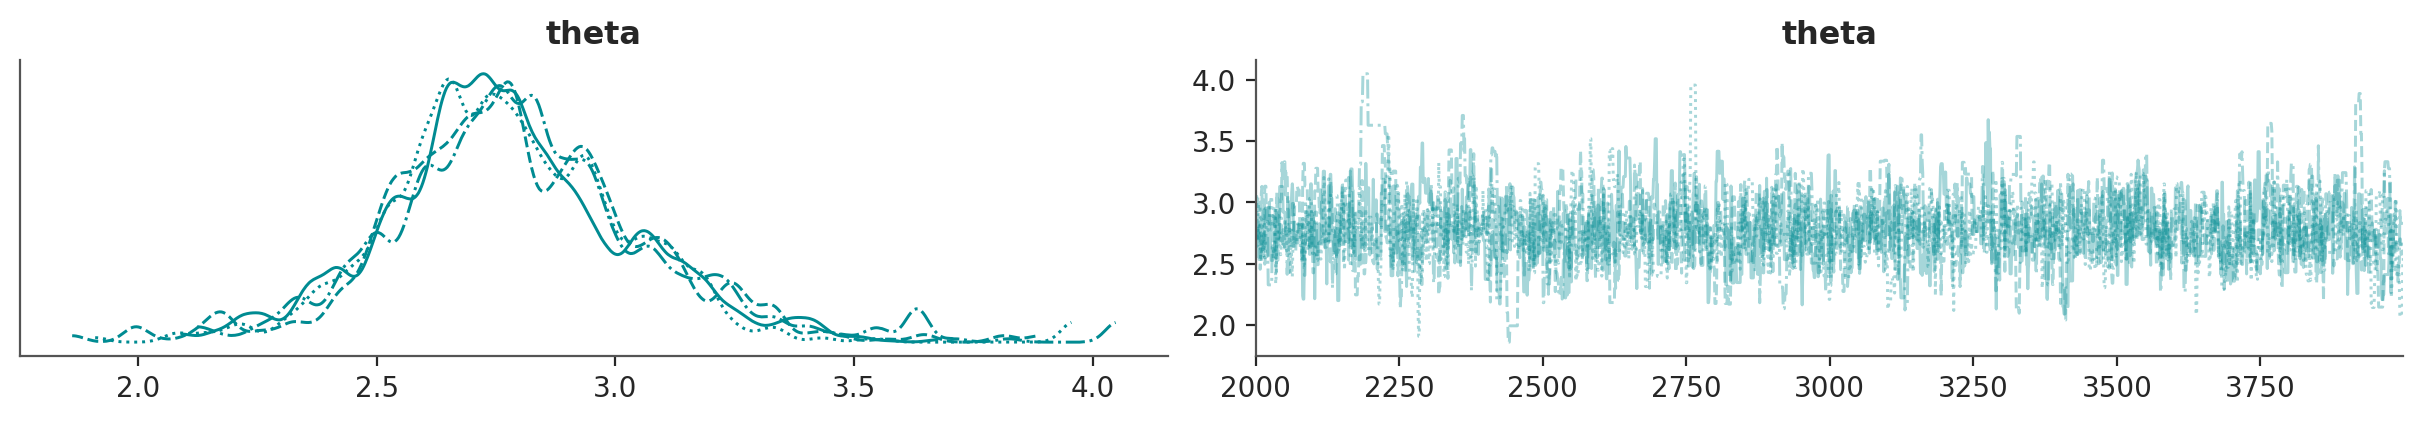

In [7]:
az.plot_trace(posterior_bsl)

## uBSL — unbiased synthetic likelihood (Price et al. 2018)

The uBSL estimator (Ghurye & Olkin 1969) is exactly unbiased for $\mathcal{N}(s_\text{obs}; \mu(\theta), \Sigma(\theta))$:

$$\hat{\ell}_\text{uBSL}(\theta) = -\frac{d}{2}\log(2\pi) + \log\frac{c(d,\, n-2)}{c(d,\, n-1)} - \frac{d}{2}\log\!\left(1 - \frac{1}{n}\right) - \frac{n-d-2}{2}\log|M_n| + \frac{n-d-3}{2}\log|A|$$

where $M_n = (n-1)\hat{\Sigma}_n$, $\;A = M_n - \dfrac{(s_\text{obs} - \hat{\mu}_n)(s_\text{obs} - \hat{\mu}_n)^\top}{1 - 1/n}$,

and $\;\log c(k, v) = -\dfrac{kv}{2}\log 2 - \dfrac{k(k-1)}{4}\log\pi - \displaystyle\sum_{i=1}^k \log\Gamma\!\left(\dfrac{v - i + 1}{2}\right)$.

In [8]:
init_pos_ubsl = [
    {"theta": jnp.array([2.0])},
    {"theta": jnp.array([4.0])},
    {"theta": jnp.array([1.0])},
    {"theta": jnp.array([3.0])},
]
posterior_ubsl = synthetic_likelihood_mcmc(
    key=jr.key(1),
    log_prior_density=log_prior_density,
    # We need higher proposal variance because uBSL returns infinite log-likelihoods far from s_obs
    proposal_covariance=jnp.array([[0.2]]),
    initial_positions=init_pos_ubsl,
    simulator=simulator,
    summary_stat=summary_stat,
    num_replicates=5,
    num_samples=4000,
    s_obs=s_obs,
    log_synlik_fn=log_synlik_ubsl,
)
posterior_ubsl = posterior_ubsl.isel(draw=slice(2000, None))

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

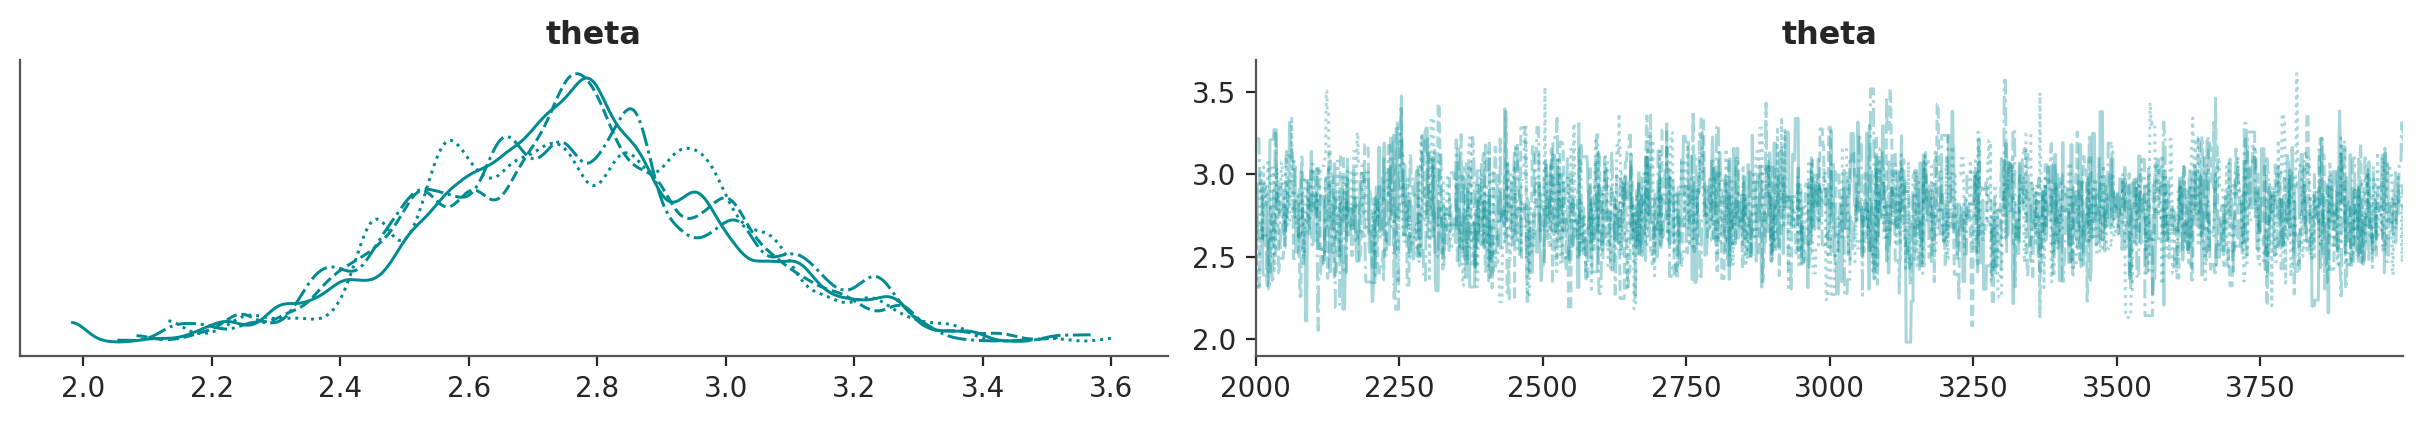

In [9]:
az.plot_trace(posterior_ubsl)

<Axes: xlabel='$\\theta$', ylabel='synthetic log-likelihood'>

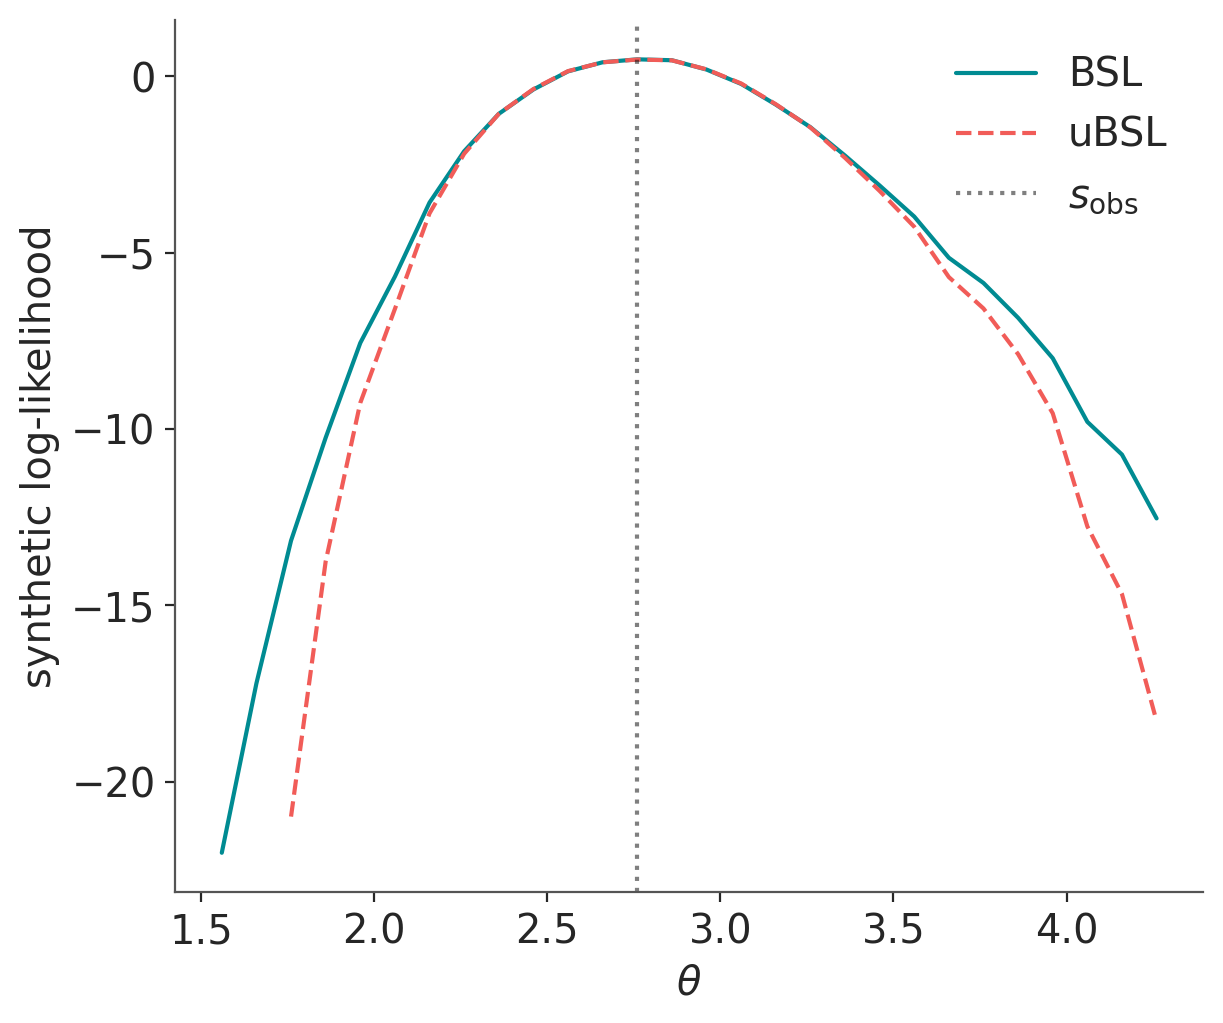

In [10]:
# XXX: uBSL is not valid far from s_obs, which makes more difficult
# to start the chain far from the truth.

_s = float(s_obs[0])
_theta_grid = np.linspace(_s - 1.2, _s + 1.5, 28)
_n_rep = 50

_bsl_curve, _ubsl_curve = [], []
_avg_keys = jax.random.split(jr.key(7), 10)
for _t in _theta_grid:
    _theta = jnp.array([_t])
    _b_acc, _u_acc = [], []
    for _k in _avg_keys:
        _sim_keys = jax.random.split(_k, _n_rep)
        _, _srep = jax.lax.scan(
            lambda _, k: (
                None,
                jnp.atleast_1d(summary_stat(simulator(k, {"theta": _theta}))),
            ),
            None,
            _sim_keys,
        )
        _b_acc.append(float(log_synlik_bsl(_srep, s_obs)))
        _u_acc.append(float(log_synlik_ubsl(_srep, s_obs)))
    _bsl_curve.append(np.mean(_b_acc))
    _ubsl_curve.append(np.mean(_u_acc))

_bsl_arr = np.array(_bsl_curve)
_ubsl_arr = np.where(np.isfinite(_ubsl_curve), _ubsl_curve, np.nan)

fig, ax = plt.subplots()
ax.plot(_theta_grid, _bsl_arr, color="C0", label="BSL")
ax.plot(_theta_grid, _ubsl_arr, color="C1", ls="--", label="uBSL")
ax.axvline(_s, color="k", ls=":", alpha=0.5, label=r"$s_\mathrm{obs}$")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("synthetic log-likelihood")
ax.legend()
plt.gca()

<Axes: ylabel='Density'>

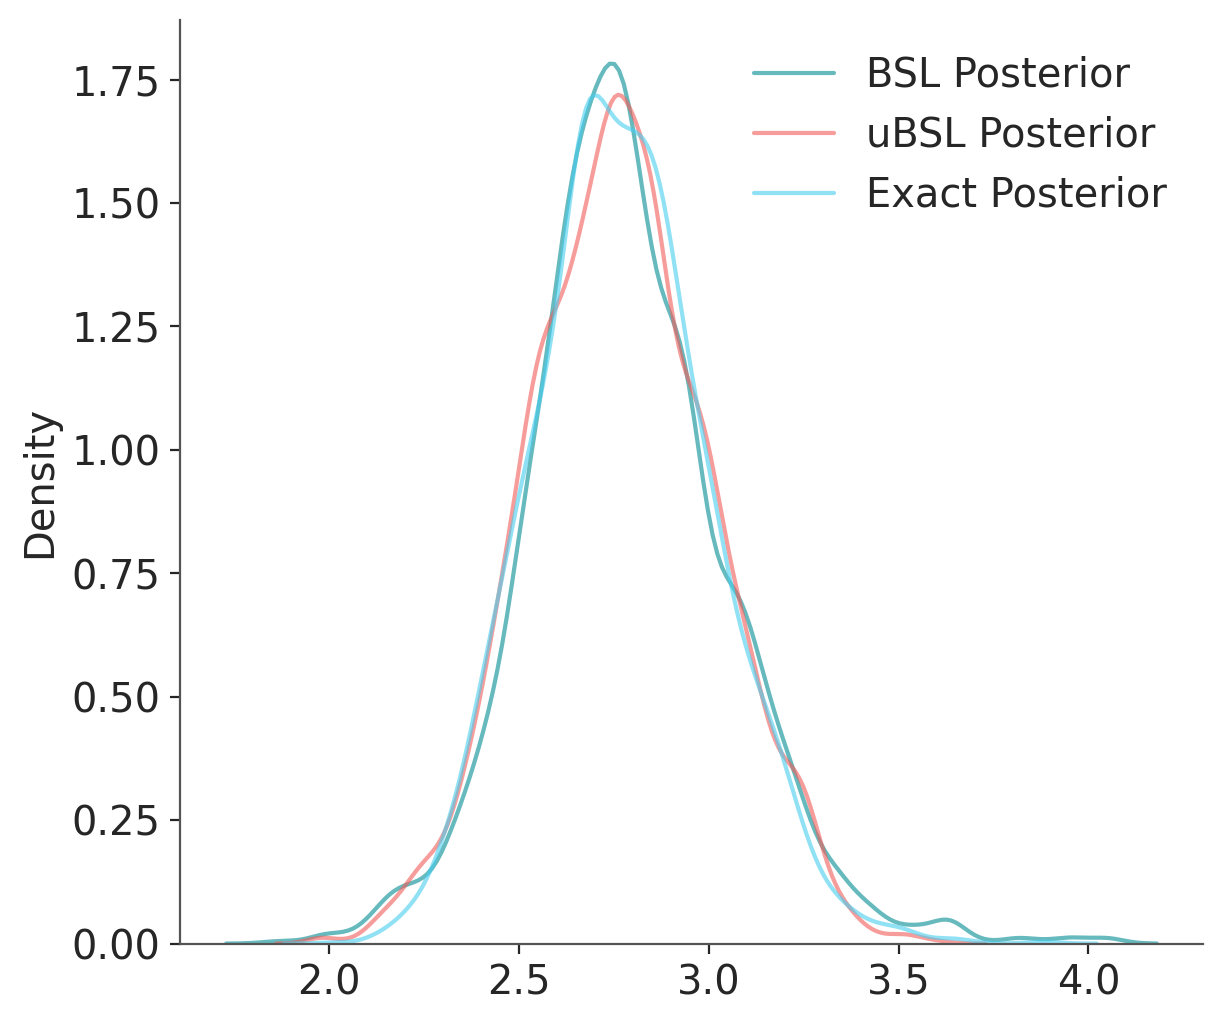

In [11]:
sns.kdeplot(
    posterior_bsl.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C0",
    label="BSL Posterior",
)
sns.kdeplot(
    posterior_ubsl.posterior["theta"].values.flatten(),
    alpha=0.6,
    color="C1",
    label="uBSL Posterior",
)
# Exact conjugate posterior
_posterior_exact = dist.Gamma(
    concentration=observed_y.sum() + 1, rate=len(observed_y)
).sample(jr.key(1), (5000,))
_posterior_exact = _posterior_exact[
    _posterior_exact < 10
]  # truncate to match prior support]
sns.kdeplot(_posterior_exact, alpha=0.6, color="C2", label="Exact Posterior")
plt.legend()
plt.gca()